# Time series regression with EnbPI, a conformal prediction method

In this example we showcase [EnbPI](http://proceedings.mlr.press/v139/xu21h/xu21h.pdf), a conformal prediction method for time series regression. For data and model definition, we follow the scikit-learn example [Time-related feature engineering](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

In [1]:
!pip install -q --upgrade pip pandas scikit-learn

## Dowloading and preparing the data

We download a bike-sharing demand dataset. Given various features, we are interested in predicting the number of bike demand over time.

In [2]:
from sklearn.datasets import fetch_openml
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
df = bike_sharing.frame

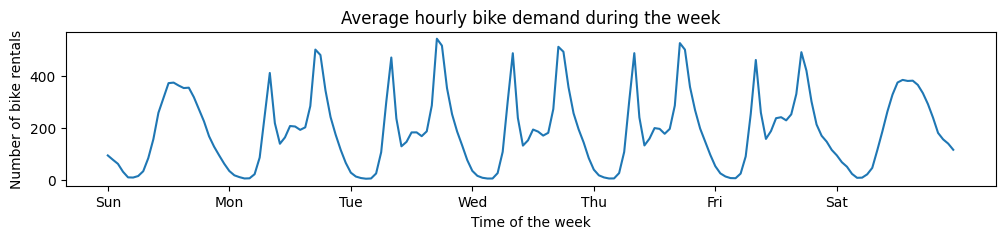

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [4]:
from sklearn.model_selection import train_test_split
y = df["count"] / df["count"].max()
X = df.drop("count", axis="columns")
X_train, X_test = train_test_split(X, test_size=0.1, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.1, shuffle=False)

## Data bootstrapping

EnbPI requires bootstrapping the data, i.e. sampling with replacement random subsets of the time series and training a model for each of these samples.

In [5]:
import numpy as np

class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples
        
    def __call__(self, X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]
    
import numpy as np
n_bs_samples = 20
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(X_train, y_train)

## Model definition 

In order to fit the time series, we define a Histogram-based Gradient Boosting Regression Tree, while encoding categorical and ordinal features.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

categorical_columns = ["weather", "season", "holiday", "workingday"]
categories = [["clear", "misty", "rain", "heavy_rain"], ["spring", "summer", "fall", "winter"], ["False", "True"], ["False", "True"],]
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(ColumnTransformer(transformers=[("categorical", ordinal_encoder, categorical_columns),], remainder="passthrough", verbose_feature_names_out=False),
                              HistGradientBoostingRegressor(categorical_features=categorical_columns,),).set_output(transform="pandas")

## Model training for each bootstrap sample

We are now ready to train the model for each of the bootstrap samples of data. For each bootstrap, we store predictions over all the training and test data points, in the format required by EnbPI.

In [7]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

## Conformal intervals with EnbPI 

We exploit the EnbPI implementation in Fortuna to compute the conformal intervals over the test data of the time series, given the training and test bootstrap predictions above. We choose a coverage error equal to 0.05, corresponding to a confidence of 95%.

In [8]:
from fortuna.conformal.regression import EnbPI
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05)

In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of test target variables that actually falls within the conformal intervals. Please note that the data points of a time series are **not** independent, therefore such percentage does not provide an unbiased estimate of the coverage probability. Nevertheless, we use this metric as a proxy. We further measure the percentage of intervals that contain the point predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals if no online feedback is provided, like in this case.

In [9]:
from fortuna.metric.regression import prediction_interval_coverage_probability
print("Percentage of intervals containing average bootstrap predictions: "
      f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}.")
print("Percentage of intervals containing true targets: "
      f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}.")
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8072497248649597.
Size of the conformal intervals: 0.16097404062747955


It is good to see that all intervals contain the respective point predictions. On the other hand, the estimated conditional coverage probability is around 80%, which is lower than the desired 95%. As mentioned above, however, the empirical metric is just a proxy, since the data points are not independent. Furthermore, EnbPI satisfies an approximate marginal coverage guarantee, not a conditional one, and only under the assumption that the residual errors in the data are identically distributed at every time step. These facts may explain the insufficient coverage observed here.

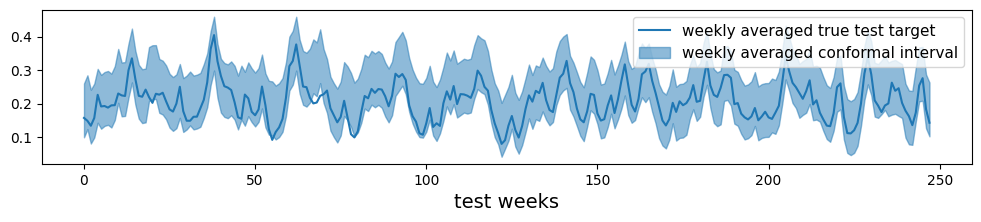

In [42]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[:s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)
    
weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]
    
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(np.arange(n_weeks), *weakly_avg(conformal_intervals).T, alpha=0.5, color="C0", label=f"weekly averaged conformal interval")
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

In the example above, EnbPI assumes that all the predictions in the test dataset are done at once, without any online feedback from incoming observations of the test targets. As a consequence, the size of the conformal intervals is the same for all test data points. However, if we work in an online setting where test targets are progressively observed, EnbPI can exploit this feedback to improve the conformal intervals. The following section provides an example of how to do this.

## EnbPI with online feedback

In this section, we assume that the test data arrives in batches and, for each task, we have to make predictions and compute conformal intervals. For simplicity, we will consider a batch size of 1 data point, i.e. we will make a prediction after each test data point arrives. Without retraining the model, we will use the residuals estimated at the very first time step, together with the feedback provided by the new predictions, to compute improved conformal intervals on the fly.

In [11]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True
        )
    else:
        conformal_intervals2[i:i+batch_size], train_residuals = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i-batch_size:i],
            bootstrap_new_test_preds=bs_test_preds[:, i:i+batch_size],
            new_train_targets=y_test.values[i-batch_size:i],
            error=0.05
        )

Similarly as done above, we compute the percentage of predictions and true test targets falling withing the conformal intervals.

In [12]:
print("Percentage of intervals containing average bootstrap predictions: "
      f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}.")
print("Percentage of intervals containing true targets: "
      f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}.")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8388952612876892.


Again, it is good to see that all conformal intervals include the point predictions. Also, while we remind that the computed percentage is just a proxy of the true coverage since the data are dependent, the percentage of intervals containing the true targets increased to around 83%, getting closer to the desired coverage of 95%.

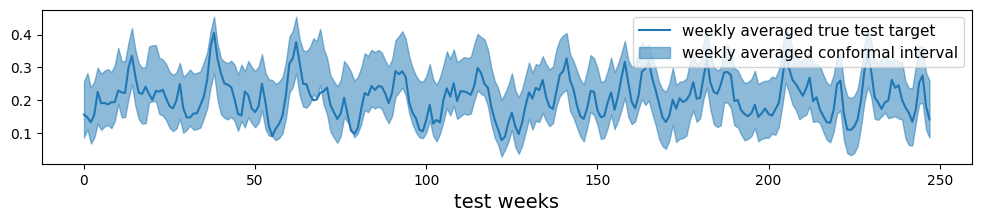

In [43]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(np.arange(n_weeks), *weakly_avg(conformal_intervals2).T, alpha=0.5, color="C0", label=f"weekly averaged conformal interval")
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

The following plot compares the size of the intervals without and with online feedback.

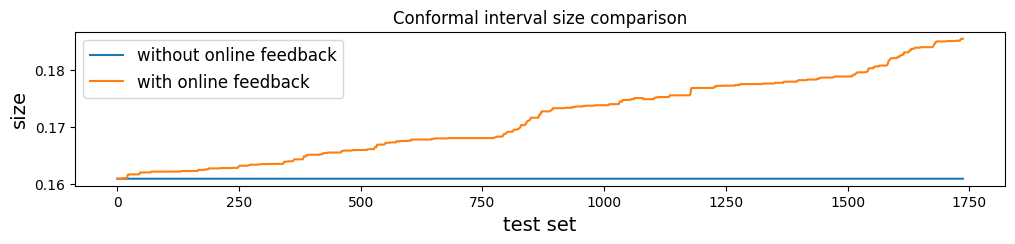

In [14]:
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

We should remark again that the feedback on the conformal intervals was provided without having to retrain the model, which is useful in practice. However, if the distribution of the data starts drifting over time, the conformal intervals may progressively become large and unusable. In such case, one may track the conformal interval size and trigger retraining after it reaches a certain threshold.

# Triggering retraining based on uncertainty

As discussed above, EnbPI allows to incorporate online feedback without retraining, which is appealing from a computational perspective. However, in particular in the occurrence of distributional shifts, retraining the model may be beneficial in order to improve predictions and reduce uncertainty. In this section, we show how one can use the size of the conformal intervals to trigger retraining. Whenever the size of the conformal intervals increases over 10% from the size of the ones computed just after retraining, then retraining is triggered. Better triggering strategies are beyond the purpose of this example.

In [15]:
retrain_percentage_increse = 0.1
init_avg_size, avg_size = 0.0, np.inf
X_train3, y_train3, X_test3, y_test3 = X_train, y_train, X_test, y_test
bs_indices3, bs_train_preds3, bs_test_preds3 = np.copy(bs_indices), np.copy(bs_train_preds), np.copy(bs_test_preds)
retrain_idx = 0

batch_size = 1
conformal_intervals3 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if avg_size > (1 + retrain_percentage_increse) * init_avg_size:
        if i != 0:
            retrain_idx = i
            X_train3, y_train3 = X[i:i+X_train.shape[0]], y[i:i+X_train.shape[0]]
            X_test3, y_test3 = X[i+X_train.shape[0]:], y[i+X_train.shape[0]:]
            bs_indices3, bs_train_data3 = DataFrameBootstrapper(n_samples=n_bs_samples)(X_train3, y_train3)
            
            for j, batch in enumerate(bs_train_data3):
                gbrt_pipeline.fit(*batch)
                bs_train_preds3[j] = gbrt_pipeline.predict(X_train3)
                bs_test_preds3[j, i:] = gbrt_pipeline.predict(X_test3)
                
        conformal_intervals3[i:i+batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices3,
            bootstrap_train_preds=bs_train_preds3,
            bootstrap_test_preds=bs_test_preds3[:, i:i+batch_size],
            train_targets=y_train3.values,
            error=0.05,
            return_residuals=True
        )
        
        init_avg_size = np.diff(conformal_intervals3[i:i+batch_size]).mean()
        avg_size = np.copy(init_avg_size)
    else:
        conformal_intervals3[i:i+batch_size], train_residuals = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds3[:, i-batch_size:i],
            bootstrap_new_test_preds=bs_test_preds3[:, i:i+batch_size],
            new_train_targets=y_test3.values[i-retrain_idx-batch_size:i-retrain_idx],
            error=0.05
        )
                  
        avg_size = np.diff(conformal_intervals3[i:i+batch_size]).mean()

The conformal interval size comparison below shows that the size of the conformal intervals goes sharply down when retraining is triggered, as expected.

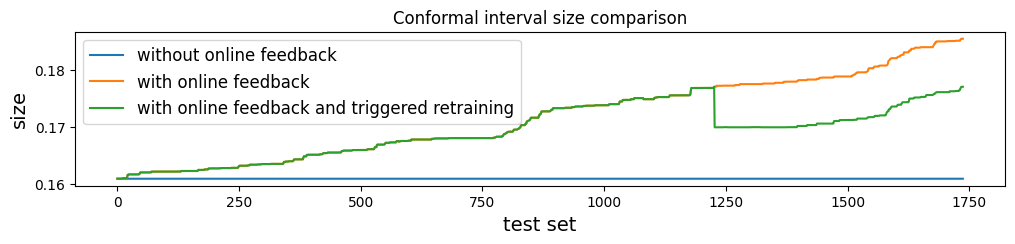

In [16]:
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.plot(np.diff(conformal_intervals3), label="with online feedback and triggered retraining")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

Furthermore, the coverage estimation seems to further improve, reaching about 85%.

In [17]:
print("Percentage of intervals containing average bootstrap predictions: "
      f"{prediction_interval_coverage_probability(*conformal_intervals3.T, bs_test_preds3.mean(0))}.")
print("Percentage of intervals containing true targets: "
      f"{prediction_interval_coverage_probability(*conformal_intervals3.T, y_test.values)}.")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8527042865753174.


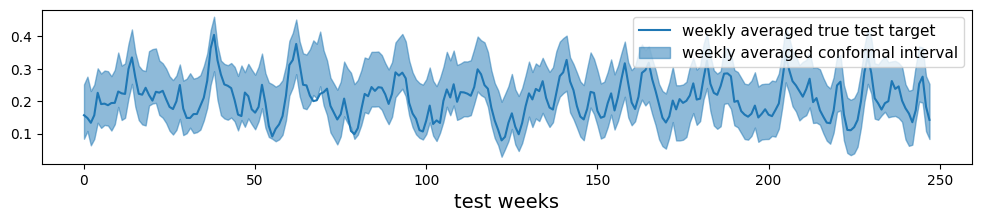

In [45]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(np.arange(n_weeks), *weakly_avg(conformal_intervals3).T, alpha=0.5, color="C0", label=f"weekly averaged conformal interval")
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")